In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

# df = pd.read_csv('processed_data.csv')

# is_not_empty = df['reviews'].str.strip().astype(bool)
# # get number of non empty reviews

# df['reviews'] = df['reviews'].str.strip()

# df = df[(df['reviews'] != "") & (df['reviews'].notna())]
# df = df[df['ratings'] > 0]
# df = df[['reviews', 'sentiment']]

# df['sentiment'] = df['sentiment'].map({'negative':0, 'neutral':1, 'positive': 2 })
# # df = df[df['sentiment'].isin([0,2])]

# df.reset_index(drop=True, inplace=True)

# df.head(20)
# print(df.shape)
# df.count()
# sentiment_counts = df['sentiment'].value_counts()
# print(sentiment_counts)

# Load your dataset
df = pd.read_csv('processed_data.csv')
df['reviews'] = df['reviews'].str.strip()
df = df[(df['reviews'] != "") & (df['reviews'].notna())]
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

df = df[['reviews', 'sentiment']]
# Calculate the minimum number of rows across sentiment categories
min_count = df['sentiment'].value_counts().min()

# Sample from each category
df_balanced = pd.concat([
    df[df['sentiment'] == 0].sample(min_count, random_state=42),
    df[df['sentiment'] == 1].sample(min_count, random_state=42),
    df[df['sentiment'] == 2].sample(min_count, random_state=42)
])

# Optionally, shuffle the rows if you want the categories to be mixed
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new balanced dataframe
print(df_balanced.head(20))
print(df_balanced.shape)
sentiment_counts_balanced = df_balanced['sentiment'].value_counts()
print(sentiment_counts_balanced)


                                              reviews  sentiment
0   use something like plug cleaner rug powering c...          0
1   disappointed pay every extra parking internet ...          1
2              better best western street staff great          2
3                room dirty didnt even want take shoe          0
4                                        satisfactory          1
5          xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx          0
6   great location bed could better overall good stay          1
7                                 nice view 4th floor          1
8   black mold around bathtub little spot mold cei...          0
9   room 204 wallpaper coming wall around window m...          0
10  staff great nice location odd older holiday in...          1
11  needed place crash night attending event area ...          1
12  three room night fine except third one smoked ...          1
13  quaint motel clean could used electric outlet ...          2
14  scary old motel rusty

## Importing Libraries

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, Embedding 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy import asarray
from numpy import zeros
from keras.layers import LSTM

# Splitting data

In [3]:
X = df['reviews']
y = df['sentiment']

In [4]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

y_train = to_categorical(y_train)
y_test= to_categorical(y_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(27979,) (27979, 3)
(6995,) (6995, 3)


# Preparing embedding layer

In [5]:
max_features = 10000
word_tokenize = Tokenizer(num_words=max_features, split=' ')
word_tokenize.fit_on_texts(X_train) # creates a dictionary mapping each unique word found in training data - this process is often called "building a vocabulary"
# ^ the frequency of each word is also calculated in this phase, this can be useful for tasks like filtering out infrequent words

X_train = word_tokenize.texts_to_sequences(X_train) # takes text and turns them into a list of numbers - each number represents a specific word in the library
X_test = word_tokenize.texts_to_sequences(X_test)

vocab_size = len(word_tokenize.word_index) + 1
maxlen = max([len(x) for x in X_train])
print(maxlen)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) # adds zeros to make sure that all of sequences have the same length
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)




323


### Creating feature matrix using GloVe word embeddings

In [6]:
embeddings_dict = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file: # iterating over every line in the glove_file
  # process each line to extract the word and its vector representation
  records = line.split()
  word = records[0]
  # the embedding word vector is obtained by converting the rest of the list
  # int a NumPy array with float32. This is needed because the the embedding dimension
  # is sorted as a string in the file and we need it to be a floating point number
  # for any mathematical operation we might perform
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dict[word] = vector_dimensions


glove_file.close()

# Creating embedding matrix 
this will contain 100 dimensional GloVe word embeddings for all words 
in our corpus.
The embedding layer of a neural network is the part of the network that takes input data by 
transforming it into dense vectors of fixed size, often at the very beginning of the model's architecture

In [7]:

# here we initialize the embedding matrix with zeros
# this creates a matrix filled with zeros where the number of rows (vocab_size)
# represents the size of our dataset's vocabulary. and the number of columns 
# represents the dimensionality of teh GloVe vectors we're using
embedding_matrix = zeros((vocab_size, 100))
# here we fill teh embedding matrix with embedding vectors from 'embeddings_dict'
for word, index in word_tokenize.word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(24590, 100)

# Recurrent Neural Net (LSTM)

In [8]:
from keras.layers import Dropout

lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(3, activation='softmax'))

In [9]:
lstm_model.compile(optimizer='adam', loss = 'categorical_focal_crossentropy', metrics=['acc'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 323, 100)          2459000   
                                                                 
 lstm (LSTM)                 (None, 323, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 2625851 (10.02 MB)
Trainable params: 166851 (651.76 KB)
Non-trainable params: 2459000 (9.38 MB)
_________________________________________________________________


#### Training LSTM model

In [10]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.3)

Epoch 1/6
154/154 [==============================] - 151s 975ms/step - loss: 0.0974 - acc: 0.6497 - val_loss: 0.0959 - val_acc: 0.6542
Epoch 2/6
154/154 [==============================] - 154s 1s/step - loss: 0.0966 - acc: 0.6523 - val_loss: 0.0959 - val_acc: 0.6542
Epoch 3/6
154/154 [==============================] - 129s 838ms/step - loss: 0.0965 - acc: 0.6523 - val_loss: 0.0960 - val_acc: 0.6542
Epoch 4/6
154/154 [==============================] - 114s 743ms/step - loss: 0.0963 - acc: 0.6523 - val_loss: 0.0965 - val_acc: 0.6542
Epoch 5/6
154/154 [==============================] - 149s 968ms/step - loss: 0.0963 - acc: 0.6523 - val_loss: 0.0960 - val_acc: 0.6542
Epoch 6/6
154/154 [==============================] - 122s 791ms/step - loss: 0.0963 - acc: 0.6523 - val_loss: 0.0959 - val_acc: 0.6542


In [11]:

# Predict probabilities
probabilities = lstm_model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(probabilities, axis=-1)

# Convert y_test from one-hot to class labels if it's one-hot encoded
y_true = np.argmax(y_test, axis=-1)

from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['Negative','Neutral', 'Positive'])

print(report)


219/219 [==============================] - 24s 109ms/step
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1278
     Neutral       0.00      0.00      0.00      1165
    Positive       0.65      1.00      0.79      4552

    accuracy                           0.65      6995
   macro avg       0.22      0.33      0.26      6995
weighted avg       0.42      0.65      0.51      6995



/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [12]:
lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)
print('lstm model score: ', lstm_score[0])
print('lstm model accuracy: ', lstm_score[1])

219/219 [==============================] - 23s 104ms/step - loss: 0.0964 - acc: 0.6508
lstm model score:  0.09635923057794571
lstm model accuracy:  0.6507505178451538


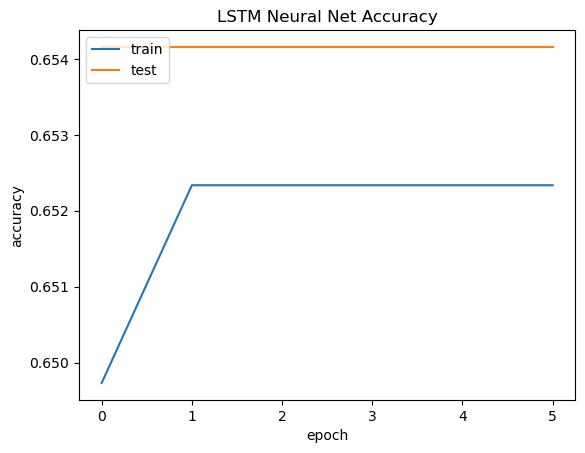

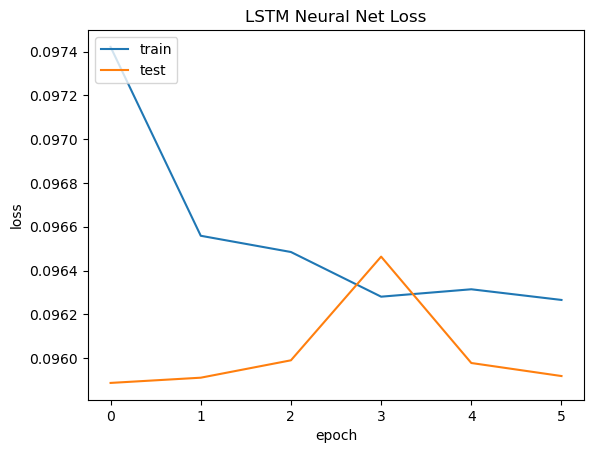

In [13]:

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('LSTM Neural Net Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('LSTM Neural Net Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

219/219 [==============================] - 23s 107ms/step


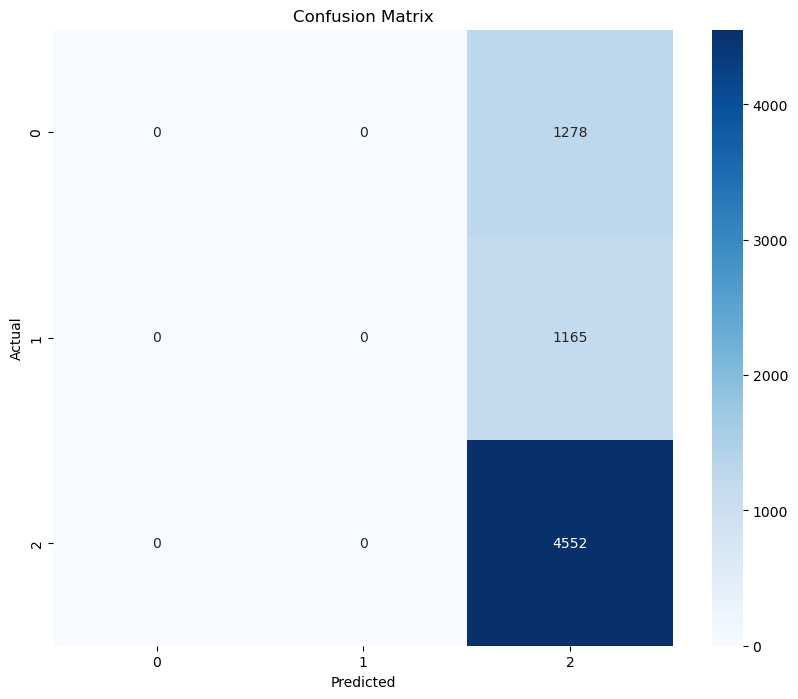

Classification Report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1278
     Class 1       0.00      0.00      0.00      1165
     Class 2       0.65      1.00      0.79      4552

    accuracy                           0.65      6995
   macro avg       0.22      0.33      0.26      6995
weighted avg       0.42      0.65      0.51      6995



/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [14]:
from sklearn.metrics import confusion_matrix 
def generate_report(model, X_test, y_test, num_classes):
    # Predict the values from the test dataset
    y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred, axis=1) 
    # Convert test observations to one hot vectors
    y_true = np.argmax(y_test, axis=1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
    # plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print the classification report
    print('Classification Report')
    target_names = ['Class {}'.format(i) for i in range(num_classes)]
    print(classification_report(y_true, y_pred_classes, target_names=target_names))

generate_report(lstm_model, X_test, y_test, 3)